# notes

- ROC-AUC for class discrimination across labels?

- do i need emotion labels or action labels

- will random forest work?

- features to capture
    - shoulder distance?
    - acceleration/directionality/amplitude of gestures bc not filtering or dropping frames
    - frequency analysis of classes like nodding or gesturing (detect repetitiveness) for scoring ?

- multiple ppl needed for dataset? only coords being captured,,,

- scoring weightages?

- nodding caputuring process:

    - Use Mediapipe to track head landmarks (e.g., nose, chin, left ear, right ear).
    - Calculate frame-to-frame positional changes:
        - Horizontal displacement for shaking.
        - Vertical displacement for nodding.
    - Apply a heuristic: If displacement alternates direction consistently over a short time, label it as nodding or shaking.

# setup

In [3]:
import mediapipe as mp
import cv2

In [4]:
mp_drawing = mp.solutions.drawing_utils # Drawing helpers
mp_holistic = mp.solutions.holistic # Mediapipe Solutions
mp_face_mesh = mp.solutions.face_mesh

In [254]:
# testing raw video + coordinates capture

cap = cv2.VideoCapture(0)

# Get screen dimensions
screen_width = 1920  # Replace with your screen width
screen_height = 1080  # Replace with your screen height

# Set window size to 90% of screen size
window_width = int(screen_width * 0.9)
window_height = int(screen_height * 0.9)

# Initiate holistic model
with mp_holistic.Holistic(min_detection_confidence=0.7, min_tracking_confidence=0.7) as holistic:
    
    while cap.isOpened():
        ret, frame = cap.read()
        
        # Recolor Feed
        image = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        image.flags.writeable = False        
        
        # Make Detections
        results = holistic.process(image)
        
        # Recolor image back to BGR for rendering
        image.flags.writeable = True   
        image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
        
        # Draw face landmarks
        mp_drawing.draw_landmarks(image, results.face_landmarks, mp_face_mesh.FACEMESH_CONTOURS, 
                                 mp_drawing.DrawingSpec(color=(80,110,10), thickness=1, circle_radius=1),
                                 mp_drawing.DrawingSpec(color=(80,256,121), thickness=1, circle_radius=1))

        # Right hand
        mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS, 
                                 mp_drawing.DrawingSpec(color=(80,22,10), thickness=2, circle_radius=4),
                                 mp_drawing.DrawingSpec(color=(80,44,121), thickness=2, circle_radius=2))

        # Left Hand
        mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS, 
                                 mp_drawing.DrawingSpec(color=(121,22,76), thickness=2, circle_radius=4),
                                 mp_drawing.DrawingSpec(color=(121,44,250), thickness=2, circle_radius=2))

        # Pose Detections
        mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS, 
                                 mp_drawing.DrawingSpec(color=(245,117,66), thickness=2, circle_radius=4),
                                 mp_drawing.DrawingSpec(color=(245,66,230), thickness=2, circle_radius=2))

        # Set window to resizable, flip footage, and move it to the center of the screen
        cv2.namedWindow('Raw Webcam Feed', cv2.WINDOW_NORMAL)
        cv2.resizeWindow('Raw Webcam Feed', window_width, window_height)
        image=cv2.flip(image,1)
        cv2.imshow('Raw Webcam Feed', image)

        # Stop when 'q' is pressed or window is closed
        if cv2.waitKey(10) & 0xFF == ord('q') or cv2.getWindowProperty('Raw Webcam Feed', cv2.WND_PROP_VISIBLE) < 1:
            break

cap.release()
cv2.destroyAllWindows()


In [6]:
# print the results of the last frame

results.pose_landmarks.landmark[0]

x: 0.570580781
y: 0.424749523
z: -1.38961434
visibility: 0.999281824

# creating dataset

In [7]:
import csv
import os
import numpy as np

import mediapipe as mp
import cv2

In [10]:
# verifying number of coordinates captured

num_coords = len(results.pose_landmarks.landmark)+len(results.face_landmarks.landmark)+len(results.left_hand_landmarks.landmark)+len(results.right_hand_landmarks.landmark)
num_coords

543

In [34]:
# Creating column headers

landmarks = ['class_name']

# Pose presence flag
landmarks.append('pose_present')

# Pose landmarks (with visibility)
for i in range(33):
    landmarks += [f'pose_x_{i}', f'pose_y_{i}', f'pose_z_{i}', f'pose_v_{i}']

# Face presence flag
landmarks.append('face_present')

# Face landmarks (with visibility)
for i in range(468):
    landmarks += [f'face_x_{i}', f'face_y_{i}', f'face_z_{i}']

# Right hand presence flag
landmarks.append('right_hand_present')

# Right hand landmarks (without visibility)
for i in range(21):
    landmarks += [f'right_x_{i}', f'right_y_{i}', f'right_z_{i}']

# Left hand presence flag
landmarks.append('left_hand_present')

# Left hand landmarks (without visibility)
for i in range(21):
    landmarks += [f'left_x_{i}', f'left_y_{i}', f'left_z_{i}']

# Print the list to check structure
print(landmarks)
print(len(landmarks))


['class_name', 'pose_present', 'pose_x_0', 'pose_y_0', 'pose_z_0', 'pose_v_0', 'pose_x_1', 'pose_y_1', 'pose_z_1', 'pose_v_1', 'pose_x_2', 'pose_y_2', 'pose_z_2', 'pose_v_2', 'pose_x_3', 'pose_y_3', 'pose_z_3', 'pose_v_3', 'pose_x_4', 'pose_y_4', 'pose_z_4', 'pose_v_4', 'pose_x_5', 'pose_y_5', 'pose_z_5', 'pose_v_5', 'pose_x_6', 'pose_y_6', 'pose_z_6', 'pose_v_6', 'pose_x_7', 'pose_y_7', 'pose_z_7', 'pose_v_7', 'pose_x_8', 'pose_y_8', 'pose_z_8', 'pose_v_8', 'pose_x_9', 'pose_y_9', 'pose_z_9', 'pose_v_9', 'pose_x_10', 'pose_y_10', 'pose_z_10', 'pose_v_10', 'pose_x_11', 'pose_y_11', 'pose_z_11', 'pose_v_11', 'pose_x_12', 'pose_y_12', 'pose_z_12', 'pose_v_12', 'pose_x_13', 'pose_y_13', 'pose_z_13', 'pose_v_13', 'pose_x_14', 'pose_y_14', 'pose_z_14', 'pose_v_14', 'pose_x_15', 'pose_y_15', 'pose_z_15', 'pose_v_15', 'pose_x_16', 'pose_y_16', 'pose_z_16', 'pose_v_16', 'pose_x_17', 'pose_y_17', 'pose_z_17', 'pose_v_17', 'pose_x_18', 'pose_y_18', 'pose_z_18', 'pose_v_18', 'pose_x_19', 'pose_y_

In [35]:
with open('coords.csv', mode='w', newline='') as f:
    csv_writer = csv.writer(f, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
    csv_writer.writerow(landmarks)

In [347]:
class_name = "hand_on_neck"


# TO-DO: 


# DONE:
# cross arms, head-in-hands, yawning, folded palms, scratching-head, hand-on-neck, hair_tucking, nail_biting, 
# thinking, covering_mouth, touching_ear, steepling_fingers, rubbing_forehead, shrugging, smiling, looking_down
# sitting_straight, slouching, waving, pointing_finger, shaking_fist, nodding, shaking_head, tugging-at-collar, 
# gesturing, idle


# NOT DOING (?):
# leaning on hand, middle-finger, showing-palm, cracking-neck

In [348]:
# Initialize MediaPipe holistic model and drawing utilities
mp_holistic = mp.solutions.holistic
mp_drawing = mp.solutions.drawing_utils

# Get screen dimensions (update these if needed)
screen_width = 1920  # Replace with actual screen width
screen_height = 1080  # Replace with actual screen height

# Set window size to 90% of screen size
window_width = int(screen_width * 0.9)
window_height = int(screen_height * 0.9)

# Open webcam
cap = cv2.VideoCapture(0)

# Start Holistic Model
with mp_holistic.Holistic(min_detection_confidence=0.7, min_tracking_confidence=0.7) as holistic:
    
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break
        
        # Convert BGR to RGB for MediaPipe
        image = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        image.flags.writeable = False
        
        # Process frame with holistic model
        results = holistic.process(image)
        
        # Convert RGB back to BGR for OpenCV rendering
        image.flags.writeable = True
        image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)

        # Draw face landmarks
        mp_drawing.draw_landmarks(image, results.face_landmarks, mp_holistic.FACEMESH_CONTOURS,
                                  mp_drawing.DrawingSpec(color=(80, 110, 10), thickness=1, circle_radius=1),
                                  mp_drawing.DrawingSpec(color=(80, 256, 121), thickness=1, circle_radius=1))

        # Draw right hand landmarks
        mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS,
                                  mp_drawing.DrawingSpec(color=(80, 22, 10), thickness=2, circle_radius=4),
                                  mp_drawing.DrawingSpec(color=(80, 44, 121), thickness=2, circle_radius=2))

        # Draw left hand landmarks
        mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS,
                                  mp_drawing.DrawingSpec(color=(121, 22, 76), thickness=2, circle_radius=4),
                                  mp_drawing.DrawingSpec(color=(121, 44, 250), thickness=2, circle_radius=2))

        # Draw pose landmarks
        mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS,
                                  mp_drawing.DrawingSpec(color=(245, 117, 66), thickness=2, circle_radius=4),
                                  mp_drawing.DrawingSpec(color=(245, 66, 230), thickness=2, circle_radius=2))

        # Extract and save landmark coordinates
        try:
            # Define default values for missing landmarks
            missing_pose = [[np.nan, np.nan, np.nan, np.nan]] * 33
            missing_face = [[np.nan, np.nan, np.nan]] * 468
            missing_hand = [[np.nan, np.nan, np.nan]] * 21  # Hands don't have visibility

            # Ensure consistent landmark extraction
            pose = [[lm.x, lm.y, lm.z, lm.visibility] for lm in results.pose_landmarks.landmark] if results.pose_landmarks else missing_pose
            face = [[lm.x, lm.y, lm.z] for lm in results.face_landmarks.landmark] if results.face_landmarks else missing_face
            right_hand = [[lm.x, lm.y, lm.z] for lm in results.right_hand_landmarks.landmark] if results.right_hand_landmarks else missing_hand
            left_hand = [[lm.x, lm.y, lm.z] for lm in results.left_hand_landmarks.landmark] if results.left_hand_landmarks else missing_hand

            # Presence flags
            pose_present= 1 if results.pose_landmarks else 0
            face_present= 1 if results.face_landmarks else 0
            right_hand_present = 1 if results.right_hand_landmarks else 0
            left_hand_present = 1 if results.left_hand_landmarks else 0

            # Flatten lists
            pose_row = list(np.array(pose).flatten())
            face_row = list(np.array(face).flatten())
            right_hand_row = list(np.array(right_hand).flatten())
            left_hand_row = list(np.array(left_hand).flatten())

            # Combine all landmark data
            row = [class_name] + [pose_present] + pose_row + [face_present] + face_row + [right_hand_present] + right_hand_row + [left_hand_present] + left_hand_row

            # Append to CSV file
            with open('coords.csv', mode='a', newline='') as f:
                csv_writer = csv.writer(f, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
                csv_writer.writerow(row)

        except Exception as e:
            print(f"Error processing frame: {e}")

        # Display the output
        cv2.namedWindow('Raw Webcam Feed', cv2.WINDOW_NORMAL)
        cv2.resizeWindow('Raw Webcam Feed', window_width, window_height)
        image=cv2.flip(image,1)
        cv2.imshow('Raw Webcam Feed', image)

        # Stop when 'q' is pressed or window is closed
        if cv2.waitKey(10) & 0xFF == ord('q') or cv2.getWindowProperty('Raw Webcam Feed', cv2.WND_PROP_VISIBLE) < 1:
            break

# Release resources
cap.release()
cv2.destroyAllWindows()


# data exploration, cleaning

In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
df = pd.read_csv('coords.csv')

df.head()

,class_name,pose_present,pose_x_0,pose_y_0,pose_z_0,pose_v_0,pose_x_1,pose_y_1,pose_z_1,pose_v_1,...,left_z_17,left_x_18,left_y_18,left_z_18,left_x_19,left_y_19,left_z_19,left_x_20,left_y_20,left_z_20
0,crossing_arms,1,0.572597,0.224525,-0.713397,0.999464,0.597508,0.180132,-0.681170,0.997778,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,crossing_arms,1,0.569808,0.224702,-0.880674,0.999447,0.595166,0.179992,-0.844131,0.997756,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,crossing_arms,1,0.568135,0.224807,-0.931058,0.999437,0.593796,0.179968,-0.894826,0.997747,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,crossing_arms,1,0.567873,0.224636,-0.924162,0.999457,0.593332,0.179589,-0.887469,0.997836,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,crossing_arms,1,0.567637,0.224155,-0.955115,0.999475,0.593094,0.178909,-0.916476,0.997922,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
# statistics of any pose group

cols = [col for col in df.columns if col.startswith("left_")]
df[cols].describe()

,left_hand_present,left_x_0,left_y_0,left_z_0,left_x_1,left_y_1,left_z_1,left_x_2,left_y_2,left_z_2,...,left_z_17,left_x_18,left_y_18,left_z_18,left_x_19,left_y_19,left_z_19,left_x_20,left_y_20,left_z_20
count,29773.000000,12940.000000,12940.000000,1.294000e+04,12940.000000,12940.000000,12940.000000,12940.000000,12940.000000,12940.000000,...,12940.000000,12940.000000,12940.000000,12940.000000,12940.000000,12940.000000,12940.000000,12940.000000,12940.000000,12940.000000
mean,0.434622,0.634572,0.619756,-4.905064e-08,0.620920,0.573571,0.002127,0.607690,0.530549,-0.000944,...,-0.029883,0.575464,0.539500,-0.037729,0.565679,0.537157,-0.038228,0.560268,0.536076,-0.037640
std,0.495716,0.125565,0.157008,2.573499e-07,0.123976,0.153964,0.011141,0.130815,0.158069,0.016053,...,0.019880,0.156665,0.193271,0.025086,0.157696,0.197548,0.027606,0.159581,0.200295,0.029903
min,0.000000,0.243268,0.162401,-9.343180e-07,0.192542,0.122665,-0.067954,0.128152,0.085917,-0.098082,...,-0.133424,0.063867,0.038296,-0.172004,0.080494,0.022985,-0.175980,0.095924,0.010928,-0.185457
25%,0.000000,0.544249,0.509655,-2.392627e-07,0.537344,0.465435,-0.004568,0.525284,0.420267,-0.010727,...,-0.043006,0.472307,0.415844,-0.053763,0.460723,0.402863,-0.056303,0.451864,0.395914,-0.057485
50%,0.000000,0.638836,0.619922,-3.720604e-08,0.624599,0.567803,0.003085,0.612628,0.523372,-0.000027,...,-0.029922,0.581412,0.540383,-0.037264,0.569912,0.535114,-0.036927,0.563016,0.531205,-0.035857
75%,1.000000,0.726203,0.730153,1.504750e-07,0.706922,0.675890,0.009362,0.693787,0.625826,0.009218,...,-0.017348,0.682335,0.650653,-0.022858,0.671024,0.644981,-0.021290,0.663903,0.649009,-0.018002
max,1.000000,1.002528,1.152375,9.470409e-07,0.994564,1.064352,0.089852,0.999092,1.076381,0.137247,...,0.110442,1.059326,1.171149,0.135861,1.088166,1.184728,0.132996,1.112769,1.194189,0.126827


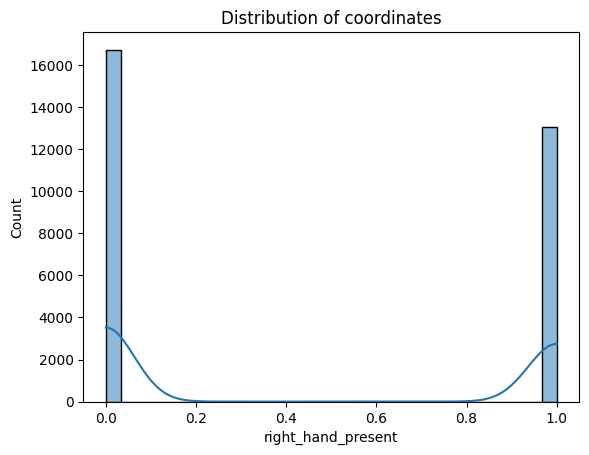

In [5]:
# Distribution of pose/face/hand x/y/z coordinate values

sns.histplot(df["right_hand_present"], bins=30, kde=True)
plt.title("Distribution of coordinates")
plt.show()

Class Distribution:
 class_name
gesturing            2803
thinking             1945
steepling_fingers    1503
crossing_arms        1484
covering_mouth       1397
hand_on_neck         1385
yawning              1373
scratching_head      1337
looking_down         1272
smiling              1250
rubbing_forehead     1244
hair_tucking         1243
nail_biting          1163
folding_palms        1126
idle                 1117
shaking_head         1097
nodding              1092
pointing_finger      1081
head_in_hands         857
sitting_straight      822
touching_ear          771
slouching             649
shrugging             560
tugging_collar        435
waving                428
shaking_fist          339
Name: count, dtype: int64


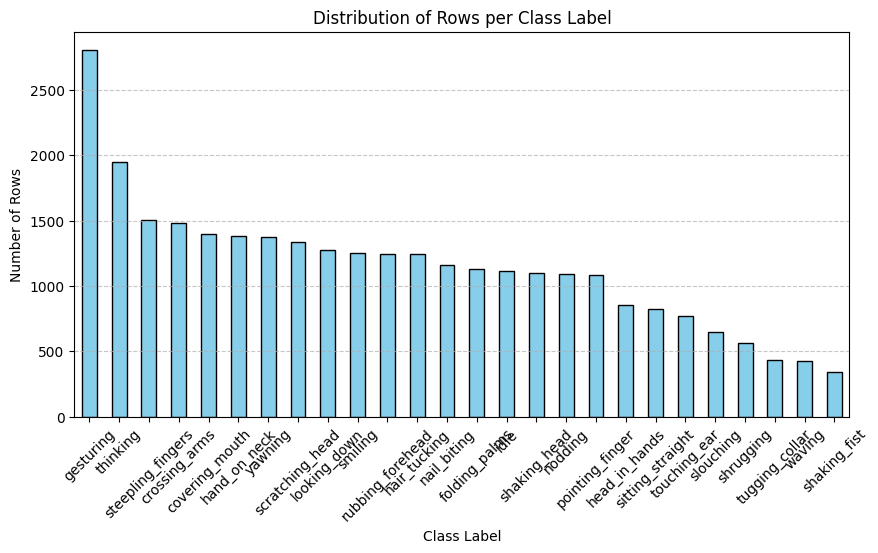

In [6]:
# Count the number of rows per class label

class_distribution = df.iloc[:, 0].value_counts()  # Assuming the first column contains class labels

# Print distribution
print("Class Distribution:\n", class_distribution)

# Plot distribution
plt.figure(figsize=(10, 5))
class_distribution.plot(kind='bar', color='skyblue', edgecolor='black')
plt.xlabel("Class Label")
plt.ylabel("Number of Rows")
plt.title("Distribution of Rows per Class Label")
plt.xticks(rotation=45)  # Rotate labels for readability
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [7]:
# what % of each column contains NaNs

pd.set_option('display.max_rows', None)  # Show all rows
print(df.isna().mean() * 100)

class_name             0.000000
pose_present           0.000000
pose_x_0               0.003359
pose_y_0               0.003359
pose_z_0               0.003359
pose_v_0               0.003359
pose_x_1               0.003359
pose_y_1               0.003359
pose_z_1               0.003359
pose_v_1               0.003359
pose_x_2               0.003359
pose_y_2               0.003359
pose_z_2               0.003359
pose_v_2               0.003359
pose_x_3               0.003359
pose_y_3               0.003359
pose_z_3               0.003359
pose_v_3               0.003359
pose_x_4               0.003359
pose_y_4               0.003359
pose_z_4               0.003359
pose_v_4               0.003359
pose_x_5               0.003359
pose_y_5               0.003359
pose_z_5               0.003359
pose_v_5               0.003359
pose_x_6               0.003359
pose_y_6               0.003359
pose_z_6               0.003359
pose_v_6               0.003359
pose_x_7               0.003359
pose_y_7

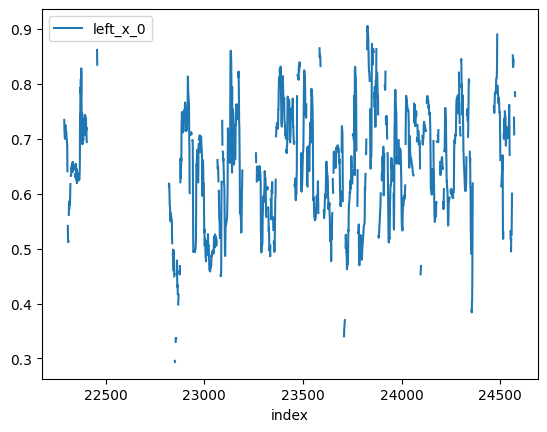

In [8]:
#check how a coordinate varies over time for a given pose

df[df['class_name'] == 'gesturing'].reset_index().plot(x='index', y='left_x_0')
plt.show()